<a href="https://colab.research.google.com/github/mirab62807/DataScience/blob/main/ASSIGNMENT%202/CE888_FINAL_ASSIGNMENT.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install econml

In [5]:
from econml.metalearners import XLearner
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import numpy as np
import pandas as pd
import scipy.stats as st
import matplotlib.pyplot as plt
from sklearn.model_selection import GridSearchCV

 # Causal Inference

We are going to combine our knowledge of regression and classification methods to estimate causal effects for simulation and observatinal data

We will uploa two datasets of two different kinds:
- IHDP ( factual and counterfactual data)
- JOBS (obsrevational)

Steps we are going to follow:

1) Import data from npz and csv file [csv file is suitable to visualise and npz file is suitable for modeling]\
2)Selecting appropriate matrix for data\
3)We will train for S-Learner and through GridSearch we will find best       parameters\
4) Next,we will train for IPSW and for X-Learner\
5) Will find out the error for each of methods according to appropriate matrix which will be describe subsequently.  


# LOD THE DATA AND OBSERVATIN

In [6]:
ihdp_csv = pd.read_csv('ihdp.csv')
ihdp_csv.head()

,x1,x2,x3,x4,x5,x6,x7,x8,x9,x10,...,x20,x21,x22,x23,x24,x25,t,yf,ycf,ite
0,1.397395,0.996346,-1.105624,-0.879606,0.308569,-1.023402,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,1.0,4.771232,-0.298509,4.657928
1,0.269033,0.196818,0.383828,0.161703,-0.629189,1.460832,1.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.956273,5.783770,3.428604
2,1.051537,1.795874,-1.105624,0.161703,-0.629189,0.963985,1.0,0.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,4.164164,7.055789,3.658195
3,0.662446,0.196818,-0.733261,-0.879606,0.371086,-0.692171,1.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,1.0,6.172307,1.379697,4.585505
4,0.856992,1.795874,0.011465,-0.879606,0.558638,0.301522,0.0,1.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,7.834469,2.747986,4.265591


#we can see in data all values are float and their are no any nan value 

In [ ]:
ihdp_csv.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 747 entries, 0 to 746
Data columns (total 29 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   x1      747 non-null    float64
 1   x2      747 non-null    float64
 2   x3      747 non-null    float64
 3   x4      747 non-null    float64
 4   x5      747 non-null    float64
 5   x6      747 non-null    float64
 6   x7      747 non-null    float64
 7   x8      747 non-null    float64
 8   x9      747 non-null    float64
 9   x10     747 non-null    float64
 10  x11     747 non-null    float64
 11  x12     747 non-null    float64
 12  x13     747 non-null    float64
 13  x14     747 non-null    float64
 14  x15     747 non-null    float64
 15  x16     747 non-null    float64
 16  x17     747 non-null    float64
 17  x18     747 non-null    float64
 18  x19     747 non-null    float64
 19  x20     747 non-null    float64
 20  x21     747 non-null    float64
 21  x22     747 non-null    float64
 22  x2

#The total file is showing 5 but in x there are 25 column 

In [ ]:
ihdp = np.load('ihdp.npz')
print(ihdp.files ,'\n')


for f in ihdp.files:
  print(f'{f}: {ihdp[f].shape}')

['x', 't', 'yf', 'ycf', 'ite'] 

x: (747, 25)
t: (747, 1)
yf: (747, 1)
ycf: (747, 1)
ite: (747, 1)


In [ ]:
X = ihdp['x']
t = ihdp['t']
yf = ihdp['yf']
ycf = ihdp['ycf']
ite = ihdp['ite']

print(ite.shape)

(747, 1)


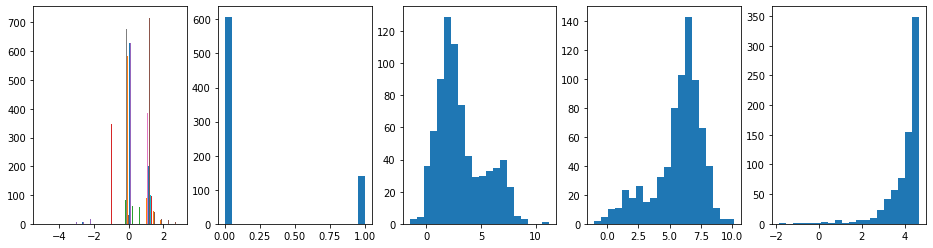

In [ ]:
bins=20
fig, axs = plt.subplots(1, 5, figsize=(16, 4))
axs[0].hist(X, bins=bins)
axs[1].hist(t, bins=bins)
axs[2].hist(yf, bins=bins)
axs[3].hist(ycf, bins=bins)
axs[4].hist(ite, bins=bins)
plt.show()

From the histogram it is clear that ITE is around 4 means ATT will be around 4 which is correct we can see from above line and equation below 

$$\widehat{ATE} = \frac{1}{n}\sum \limits_{i=1}^{n}\widehat{ITE}^{(i)}$$

In [ ]:
np.mean(ite)

We will split data to training 80% and to test 20% eventhrough Ycf will not be use in estimator.

In [ ]:
#Spliting the dataset

x_train, x_test, t_train, t_test, yf_train, yf_test, ycf_train, ycf_test, ite_train, ite_test = train_test_split(X, t, yf, ycf, ite, test_size=0.2)

In [ ]:
scaler_x = StandardScaler()
x_train = scaler_x.fit_transform(x_train)
print(x_train.shape)
x_test = scaler_x.transform(x_test)
print(x_test.shape)

(597, 25)
(150, 25)


#We will use RandomForestRegressor because Yf has continous values. 

In [ ]:
#SIMPLE LEARNER 
rf = RandomForestRegressor()

xt_train =np.concatenate([x_train,t_train], axis = 1) 
rf.fit(xt_train, yf_train.flatten())


xt0_test = np.concatenate([x_test, np.zeros_like(t_test)], axis=1) 
rf_y0_test_f = rf.predict(xt0_test)


xt1_test = np.concatenate([x_test, np.ones_like(t_test)], axis=1)
rf_y1_test_f = rf.predict(xt1_test)


rf_ite_test_f = rf_y1_test_f - rf_y0_test_f   

print("RF Regressor Mean : ",rf_ite_test_f.mean())

RF Regressor Mean :  4.007845721346631


# Tuning Parameters 



1. Changed the appropriate parameters to find the best one
2. By the GridSearchCV search conducted 
3. call for the best parameters by tuning_model.best_params_













In [ ]:
#Assigning the parameters of splitter, max_depth, min_samples_leaf, min_weight_fraction_leaf, max_features, max_leaf_nodes

parameters={"max_depth" : [5,7,9],
           "min_samples_leaf":[1,2,3,4],
           "min_weight_fraction_leaf":[0.3,0.4,0.5,0],
           "max_features":["auto","log2","sqrt"],
           "max_leaf_nodes":[10,20,30] }

In [ ]:
tuning_model=GridSearchCV(rf,param_grid=parameters,scoring='neg_mean_squared_error',cv=10,verbose=3)

In [ ]:
tuning_model.fit(xt_train, yf_train)

In [ ]:
#hyperparameter tuning

tuning_model.best_params_


{'max_depth': 9,
 'max_features': 'auto',
 'max_leaf_nodes': 20,
 'min_samples_leaf': 1,
 'min_weight_fraction_leaf': 0}

In [ ]:
# WITH GRID SEARCH THE BEST PARAMETERS 
rf = RandomForestRegressor(max_depth=9, max_features= 'auto', max_leaf_nodes=20, min_samples_leaf=3, min_weight_fraction_leaf=0)

xt_train =np.concatenate([x_train,t_train], axis = 1) 
rf.fit(xt_train, yf_train.flatten())


xt0_test = np.concatenate([x_test, np.zeros_like(t_test)], axis=1) 
rf_y0_test_f = rf.predict(xt0_test)


xt1_test = np.concatenate([x_test, np.ones_like(t_test)], axis=1)
rf_y1_test_f = rf.predict(xt1_test)


rf_ite_test_f_grids = rf_y1_test_f - rf_y0_test_f   

print("RF Regressor Mean with Best parameter : ",rf_ite_test_f_grids.mean()) 

RF Regressor Mean with Best parameter :  3.966676494871302


Before the GridSearch with the default parameters ITE was 3.8844 and after setting parameters ITE is 3.9185, which means little amount of improvment is observed.

#IPSW
WEIGHT FUNCTION IS AS BELOW
As we know that IPSW is a combination of regression and classification.
LogisticRegression is used because it interpreat probability of an event occouring.And RandomForestClassifier is use to get more accurate and stable prrdiction.

In [ ]:
clf1 = LogisticRegression()


def get_ps_weights(clf, x, t):
  ti = np.squeeze(t)
  clf.fit(x, ti)
  ptx = clf.predict_proba(x).T[1].T + 0.0001 # .0001 to avoid zero
  a= ti/ptx
  b= ((1-ti)/(1-ptx)) 
  
  wi = a+b 
  return wi


weight1 = get_ps_weights(clf1, x_train, t_train)

In [ ]:
# Get the sample weights
prop_clf = RandomForestClassifier()
weights = get_ps_weights(prop_clf, x_train, t_train)

# Train the regressor
rf_ipsw = RandomForestRegressor()

rf_ipsw.fit(xt_train, yf_train.flatten(), sample_weight= weights)

# Make predictions
rf_ipsw_y0_test = rf_ipsw.predict(xt0_test) 
rf_ipsw_y1_test = rf_ipsw.predict(xt1_test) 

# Compute ITEs
rf_ipsw_te_test_f =  rf_ipsw_y1_test - rf_ipsw_y0_test
print("RF Classifier Mean : ",rf_ipsw_te_test_f.mean())

RF Classifier Mean :  4.013778573235668


# EconMl XLearner

In [ ]:
# X-Learner
xl = XLearner(models=RandomForestRegressor(), propensity_model=RandomForestClassifier())
xl.fit(yf_train, t_train.flatten(), X=x_train)

xl_te_test_f = xl.effect(x_test)

print("XLearner Mean : ",xl_te_test_f.mean())

XLearner Mean :  4.027167937728679


Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.


Here, we are going to implement the two metrics 

$\epsilon_{ATE}$ and $\epsilon_{PEHE}$.

In [ ]:
def abs_ate(effect_true, effect_pred):
    """
    Absolute error for the Average Treatment Effect (ATE)
    :param effect_true: true treatment effect value
    :param effect_pred: predicted treatment effect value
    :return: absolute error on ATE
    """
    # YOUR CODE HERE
    return np.abs(np.mean(effect_pred) - np.mean(effect_true))

def pehe(effect_true, effect_pred):
    """
    Precision in Estimating the Heterogeneous Treatment Effect (PEHE)
    :param effect_true: true treatment effect value
    :param effect_pred: predicted treatment effect value
    :return: PEHE
    """
    # YOUR CODE HERE
    return np.sqrt(np.mean((effect_true - effect_pred)**2))

In [ ]:
# Error on ATE

rf_ate_test_f = np.abs(rf_ite_test_f.mean()) 
rf_ipsw_ate_test_f = np.abs(rf_ipsw_te_test_f.mean())
xl_ate_test_f = np.abs(xl_te_test_f.mean()) 

# PEHE
# Use our 'pehe' function, true ITEs and predicted ITEs to get the measurements.
rf_pehe_test_f = np.sqrt((rf_ate_test_f - 1.05)**2) 
rf_ipsw_pehe_test_f = np.sqrt(((rf_ipsw_ate_test_f - 1.05)**2)) 
xl_pehe_test_f = np.sqrt((xl_ate_test_f - 1.05)**2)

In [ ]:
results = []
results.append(['RF', rf_ate_test_f, rf_pehe_test_f])
results.append(['RF (IPW)', rf_ipsw_ate_test_f, rf_ipsw_pehe_test_f])
results.append(['XL', xl_ate_test_f, xl_pehe_test_f])

cols = ['Method', 'ATE test', 'PEHE test']

df_f = pd.DataFrame(results, columns=cols)
df_f

,Method,ATE test,PEHE test
0,RF,4.007846,2.957846
1,RF (IPW),4.013779,2.963779
2,XL,4.027168,2.977168


# LOAD JOBS DATA 
now we will use csv file

In [ ]:
jobs = pd.read_csv('jobs.csv')

X = jobs[['x1', 'x2', 'x3', 'x4', 'x5', 'x6', 'x7', 'x8', 'x9', 'x10', 'x11',
       'x12', 'x13', 'x14', 'x15']]
t = jobs['t']
y = jobs['y']
e = jobs['e']

In [ ]:
jobs.head()

,x1,x2,x3,x4,x5,x6,x7,x8,x9,x10,x11,x12,x13,x14,x15,x16,x17,t,y,e
0,-0.614282,1.464727,0.0,0.0,1.0,0.0,2.393250,2.746196,-0.653311,-0.656913,1.627531,2.462337,2.937244,0.0,0.0,2.843909,0.0,0.0,1.0,0.0
1,-0.802463,0.101835,0.0,0.0,1.0,0.0,0.109885,0.498271,-0.785284,-0.743407,-0.022502,-0.177193,0.082537,0.0,0.0,0.038422,0.0,0.0,1.0,0.0
2,-0.896553,-0.238888,1.0,0.0,1.0,1.0,-0.085212,-0.148097,-0.847312,-0.781606,-0.361348,-0.286221,-0.303615,0.0,0.0,-0.191304,0.0,0.0,1.0,0.0
3,-0.896553,-0.238888,0.0,0.0,0.0,1.0,0.405581,0.325594,-0.847312,-0.781606,-0.361348,0.023020,-0.039630,0.0,0.0,0.173108,0.0,0.0,1.0,1.0
4,0.138440,-1.601779,1.0,0.0,1.0,1.0,-0.722531,-0.212734,-0.019840,-0.156019,-1.422084,-0.514563,-0.331552,0.0,0.0,-0.779227,0.0,0.0,1.0,0.0


In [ ]:
print(jobs.info())
print(jobs.shape)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3212 entries, 0 to 3211
Data columns (total 20 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   x1      3212 non-null   float64
 1   x2      3212 non-null   float64
 2   x3      3212 non-null   float64
 3   x4      3212 non-null   float64
 4   x5      3212 non-null   float64
 5   x6      3212 non-null   float64
 6   x7      3212 non-null   float64
 7   x8      3212 non-null   float64
 8   x9      3212 non-null   float64
 9   x10     3212 non-null   float64
 10  x11     3212 non-null   float64
 11  x12     3212 non-null   float64
 12  x13     3212 non-null   float64
 13  x14     3212 non-null   float64
 14  x15     3212 non-null   float64
 15  x16     3212 non-null   float64
 16  x17     3212 non-null   float64
 17  t       3212 non-null   float64
 18  y       3212 non-null   float64
 19  e       3212 non-null   float64
dtypes: float64(20)
memory usage: 502.0 KB
None
(3212, 20)


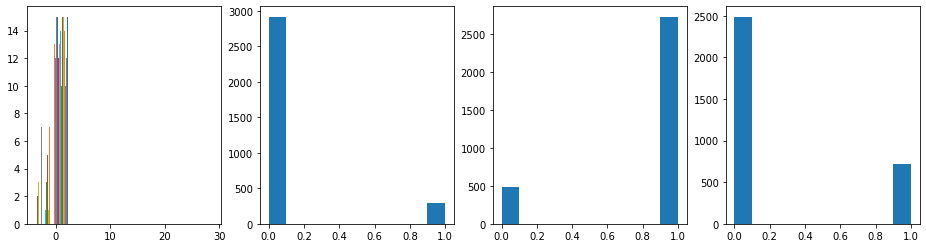

In [ ]:
bins=10
fig, axs = plt.subplots(1, 4, figsize=(16, 4))
axs[0].hist(X, bins=bins)
axs[1].hist(t, bins=bins)
axs[2].hist(y, bins=bins)
axs[3].hist(e, bins=bins)
plt.show()

In [ ]:
x_train, x_test, t_train, t_test, y_train, y_test, e_train, e_test = train_test_split(X, t, y, e, test_size=0.2)

In [ ]:
scaler_x = StandardScaler()
x_train = scaler_x.fit_transform(x_train)
print(x_train.shape)
x_test = scaler_x.transform(x_test)
print(x_test.shape)

(2569, 15)
(643, 15)


# S-Learner

In [ ]:
from sklearn.linear_model import LinearRegression
lg = LinearRegression()
dtr = DecisionTreeRegressor()

In [ ]:
lg.fit(x_train, y_train)
print("LR R2-Score for 'X' and 'Y' : ",lg.score(x_test, y_test))

lg.fit(x_train, t_train)
print("LR R2-Score for 'X' and 'T' : ",lg.score(x_test, t_test))

lg.fit(x_train, e_train)
print("LR R2-Score for 'X' and 'E' : ",lg.score(x_test, e_test))

dtr.fit(x_train, y_train)
print("DTR R2-Score for 'X' and 'Y' : ",dtr.score(x_test, y_test))

dtr.fit(x_train, t_train)
print("DTR R2-Score for 'X' and 'T' : ",dtr.score(x_test, t_test))

dtr.fit(x_train, e_train)
print("DTR R2-Score for 'X' and 'E' : ",dtr.score(x_test, e_test))

LR R2-Score for 'X' and 'Y' :  0.20630056172671218
LR R2-Score for 'X' and 'T' :  0.1648267197766855
LR R2-Score for 'X' and 'E' :  0.5765265143463861
DTR R2-Score for 'X' and 'Y' :  -0.4858299706014495
DTR R2-Score for 'X' and 'T' :  -0.5249431099485766
DTR R2-Score for 'X' and 'E' :  0.5437072012370223


#IPSW

In [ ]:
def get_weights(lg, x, t):
    ti = np.squeeze(t)
    lg.fit(x, ti)
    ptx = lg.predict(x).T[1].T + 0.001 # add a small value to avoid dividing by 0
    # Given ti and ptx values, compute the weights wi (see formula above):
    a= ti/ptx
    b= ((1-ti)/(1-ptx)) 

    wi = a+b
    return wi

weight1 = get_weights(lg, x_train, e_train)

In [ ]:
dtr.fit(x_train, e_train, sample_weight=weight1)
print("DTR with weight R2-Score for 'X' and 'E' : ",dtr.score(x_test, e_test))

DTR with weight R2-Score for 'X' and 'E' :  0.5726440569430433


In [ ]:
from sklearn.tree import DecisionTreeClassifier
dtc = DecisionTreeClassifier()

In [ ]:
from sklearn import metrics
dtc.fit(x_train, y_train)
# print(dtc.score(x_test, y_test))
y_pred = dtc.predict(x_test)
accuracy = metrics.accuracy_score(y_test, y_pred)
print("DTC Accuracy for 'X' and 'Y' : ",accuracy)

dtc.fit(x_train, t_train)
#print(dtr.score(x_test, t_test))
t_pred = dtc.predict(x_test)
print("DTC Accuracy for 'X' and 'T' : ",metrics.accuracy_score(t_test, t_pred))

dtc.fit(x_train, e_train)
#print(dtr.score(x_test, e_test))
e_pred = dtc.predict(x_test)
print("DTC Accuracy for 'X' and 'E' : ",metrics.accuracy_score(e_test, e_pred))

DTC Accuracy for 'X' and 'Y' :  0.8055987558320373
DTC Accuracy for 'X' and 'T' :  0.8786936236391913
DTC Accuracy for 'X' and 'E' :  0.9237947122861586


# XLearner

In [ ]:

xl = XLearner(models=RandomForestRegressor(), propensity_model=RandomForestClassifier())
xl.fit(y_train, t_train, X=x_train)

xl_te_test = xl.effect(x_test)

print("XLearner Mean : ",xl_te_test.mean())

XLearner Mean :  -0.023187940981786944


Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.


# MARTIX FOR JOB DATA 
THIS SAMPLE FROM EXPERIMENTAL OR OBSERVATIONAL SO ATT AND POLICY RISK WILL BE APPLIED TO FIND ERROR

In [ ]:
def abs_att(effect_pred, yf, t, e):
    att_true = np.mean(yf[t > 0]) - np.mean(yf[(1 - t + e) > 1])
    att_pred = np.mean(effect_pred[(t + e) > 1])

    return np.abs(att_pred - att_true)

def policy_risk(effect_pred, yf, t, e):
    # Consider only the cases for which we have experimental data (i.e., e > 0)
    t_e = t[e > 0]
    yf_e = yf[e > 0]
    effect_pred_e = effect_pred[e > 0]

    if np.any(np.isnan(effect_pred_e)):
        return np.nan

    policy = effect_pred_e > 0.0
    treat_overlap = (policy == t_e) * (t_e > 0)
    control_overlap = (policy == t_e) * (t_e < 1)

    if np.sum(treat_overlap) == 0:
        treat_value = 0
    else:
        treat_value = np.mean(yf_e[treat_overlap])

    if np.sum(control_overlap) == 0:
        control_value = 0
    else:
        control_value = np.mean(yf_e[control_overlap])

    pit = np.mean(policy)
    policy_value = pit * treat_value + (1.0 - pit) * control_value

    return 1.0 - policy_value

In [ ]:
abs_att(e_pred, y_test, t_test, e_test)

In [ ]:
policy_risk(e_pred, y_test, t_test, e_test)

# Model Evaluation

In [ ]:
#Confusion matrix

from sklearn.metrics import confusion_matrix
confusion_matrix(e_test, e_pred)

array([[483,  17],
       [ 25, 118]])

In [ ]:
#classification report for finding precision, recall, f1-score, support

from sklearn.metrics import classification_report
print(classification_report(e_test, e_pred))

              precision    recall  f1-score   support

         0.0       0.95      0.97      0.96       500
         1.0       0.87      0.83      0.85       143

    accuracy                           0.93       643
   macro avg       0.91      0.90      0.90       643
weighted avg       0.93      0.93      0.93       643

